# Implementation Study of DeepTriage: Deep Learning for Bug Report Classification

#### Author: Patrick de Guzman

####  Emails: pdeguzman@ryerson.ca

# Introduction:

#### Problem Description:

Software engineering teams for large software applications receive a plethora of bug reports outlining issues with various aspects of their applications. With the increasing complexity of software, bug reports come in larger numbers and in greater variety, presenting a problem for both developers solving bugs and the processes/members responsible for assigning bugs to appropriate developers for effective resolution (the bug triaging problem). 

Bug triaging presents a challenging NLP classification task given the nature of bug reports. Bug reports are generated by end users and are typically a combination of formal language/sentences as well as code stacks (e.g., java/python functions, other code, bug traces). This generates noise in the data which makes it difficult for models to separate classes in classification. 

The paper "DeepTriage: Exploring the Effectiveness of Deep Learning for Bug Triaging" explores a deep neural network to capture syntactical and sequential word information present in bug reports. More specifically, they present a deep bi-directional recurrent neural network with Word2Vec embeddings and a soft attention mechanism (DBRNN-A). After processing bug report data for several different software data sources, they compare rank-10 classification performance between their DBRNN-A and standard bag-of-word (BOW) models found in related literature. 

#### Context of the Problem:

In the domain of software engineering, the bug triaging classification problem is relevant because of the growing complexity of softwares, teams, and the processes underpinning their effective operations. Bottlenecks in effective bug triaging processes can strain developer resources and time which already face severe constraints, particularly in technology companies where there are many ongoing projects and little time to waste on menial tasks. Automated bug triaging can help tremendously in operational efficiency, thus, trickling its benefits to the team's general operations through time savings. In addition, an automated bug triaging solution that is capable of finding the right developer for a particular problem should, theoretically, reduce total time to resolution for bugs by assigning developers based on past experience on certain types of bugs because developers with repeated experience in special areas of troubleshooting benefit from higher transfer learning with their past experience.  

Outside of the software engineering domain, the bug triaging problem can be viewed as an important area for understanding noisy textual data in general, as well as the types of processing and modeling methods that are effective in extracting the relevant contextual/semantic information for related problems. 

#### Limitation About other Approaches:

Prior approaches to bug triaging have limitations in their ability to capture semantic information from the text descriptions of bugs. More specifically, BOW models treat text as an unordered collection of words, eliminating the hidden meaning behind their sequences. 

#### Solution:

Deep RNNs (as used in the DeepTriage paper) can extract such sequential information to improve classification performance. It does this through long short-term memory (LSTM) layers, treating each bug report description as a sequence and learning from word to word in order to capture additional information from the text. The authors also employ a soft attention mechanism which further allows the model to distinguish which parts of the bug description are most important for the task at hand which, theoretically, reduces noise in the data. 

# Background

Explain the related work using the following table

| Reference |Explanation |  Dataset/Input |Accuracy | Weakness
| --- | --- | --- | --- | --- |
| Bhattacharya et al., 2010 [2] | Trained Naive Bayes model with BOW and TF-IDF feature vectors | Eclipse & Mozilla bug data: bug titles, descriptions, product, component, developer activity | Rank-5 accuracy: 77% | Does not capture semantic context through BOW
| Tamrawi et al., 2011 [3] | Trained 'fuzzy-set' features for word tokens | Eclipse bug data: bug titles, descriptions | Rank-5 accuracy: 68% | Does not capture semantic context through BOW
| Mani et al. [1] | Trained Bi-LSTM model with attention mechanism & Word2Vec embeddings, compared against BOW classifiers | Mozilla, Chromium data: bug titles, descriptions for triaged & untriaged bugs | Rank-10 accuracy: 46% | No rank-5 accuracy as baseline, lower rank-10 accuracy, 


# Methodology

The model proposed by Mani et al. [1] is a bi-directional LSTM with a soft attention layer (termed as 'DBRNN-A'). The figures below are directly from the DeepTriage paper. 
To implement the DBRNN-A, the approach is shown below where all bug reports in the dataset are first cleaned (stripped of URLs, stack traces, tokenized, and case folded) (steps 1-3). Afterwards, all bugs (untriaged and triaged) are used for training a Deep learning-based bug feature representation via Word2Vec (step 5). Using these Word2Vec embeddings, the DBRNN-A model is trained only on the triaged bugs (since these are the instances with actual labels) (steps 6-10). 

This project will implement this DBRNN-A model, along with the BOW models (MNB and Logistic Regression/Softmax). The model runs are repeated for 10-fold validation on the dataset, and re-run for varying training thresholds per label. Training thresholds are defined as the minimum number of training instances per unique label in the dataset, and the parameters run are 0, 5, 10, and 20 threshold instances. This training threshold filtration is performed as there are many developers with very few bug report instances, generating noise and imbalance in the dataset.

![DT_approach](figures/DT_approach.png "DeepTriage Approach")

The DBRNN-A model architecture is shown below: 

![DT_model](plots/model_plots/dbrnna_model_plot.png "DeepTriage Model")

Based on their implementation, below shows the results of the DBRNN-A model that we'll use to compare against the performance obtained in this replication project. Most notably, a subset of the Chromium bug report dataset will be used for this project, and results will be compared against the highest performing model (with minimum training threshold of 20 instances per label).

![DT_results](figures/DT_results.png "DeepTriage Results")

In extension of the paper, I also explore tuning of the size of the units for LSTM and Dense layers in the DBRNN-A model to assess whether the proposed architecture by Mani et al. [1] is optimal, or might have room for exploration in hyperparameter tuning. 


# Implementation


In [7]:
#LIBRARIES
import src.processing as p
import imp; imp.reload(p)

import pandas as pd
import os

To generate the Word2vec embeddings, we first gather both triaged and untriaged bugs in the dataset (at a sample 'frac' size for each) and concatenate these to generate an 'all_bugs' set. The function read_process_data() currently cleans and tokenizes the full dataset per the processing steps outlined by Mani et al. [1]. 

In [8]:
#READING & PROCESSING DATA
triaged, untriaged, label_map = p.read_process_data(overwrite=False, 
                                                    triaged_frac=0.1, 
                                                    untriaged_frac=0.3)
untriaged.columns = ['X']
print(triaged.head())
print(label_map.head())

                                                   X     y
0  add uma tracking to ntp  sign in  link see tit...   300
1   chaos lab  install initial aps on chromeos3-r...   370
2  windows should not open maximized on aura we w...  1317
3  replace default thumbnail for themes on most v...   437
4  add gallery browser tests to crop an image  ve...   564
   code                  label
0     0   *idanan@chromium.org
1     1      *mdu@chromium.org
2     2      *sjl@chromium.org
3     3      a...@chromium.org
4     4  a.suchit@chromium.org


In [9]:
#BUILD WORD2VEC EMBEDDINGS ON TRIAGED + UNTRIAGED DATA
all_bugs = pd.concat([triaged['X'], untriaged['X']], axis=0).reset_index(drop=True)
all_bugs = all_bugs.astype(str)

Using all bugs, we then train our Word2Vec model using a vector size of 200 and window of 5 per word. The embedding indices are also generated, and stored separately for ease of access to all models. 

In [10]:
p.build_custom_emb_model(data=all_bugs, 
                        vector_size=200, 
                        min_count=5, 
                        window=5, 
                        overwrite=False)
p.build_emb_indices()
p.build_results_dfs(overwrite = False)

### Model Runs

In [19]:
import src.model_dbrnna as dbrnna
import src.model_dbrnna_mod as dbrnna_mod
import src.model_bow as bows

All models are run below (beware, these take a long time to run!). The 'bows' script contains functionality to run BOW models for 2 different classifiers: MNB and LOG. 
In addition, 'dbrnna_mod' utilizes the same architecture as the proposed DBRNN-A model, but with additional functionality to adjust the number of units in both LSTM and intermediate Dense layers. 

In [ ]:
%%capture
bows.run() 
dbrnna.run()
dbrnna_mod.run(lstm_units=512, layer_units=300)
dbrnna_mod.run(lstm_units=300, layer_units=512)
dbrnna_mod.run(lstm_units=300, layer_units=300)

### Results

For the first round of results, we compare the BOW models against the proposed DBRNN-A, similar to how Mani et al. [1] has formatted their results. 
In the below implementation, we only view the accuracy by top-10 since this will be the highest performing of the models.

In [12]:
#Results processing
models = ['bow_mnb', 'bow_log', 'dbrnna']
results = pd.read_csv(os.path.join(os.getcwd(), 'results/results.csv'))
results.query(f"classifier in {models} and metric == 'top_n' and metric_n == 10", inplace=True)
results[[c for c in results.columns if 'cv_' in c]] = results[[c for c in results.columns if 'cv_' in c]].round(4)*100.0

In [13]:
#Plotting
import matplotlib.pyplot as plt
import numpy as np
def bar_plots(models, results, orient_x='horizontal', leg_loc=2):
    classes = models
    thresholds = [0, 5, 10, 20]
    colors = ['cyan', 'orange', 'green', 'brown']
    widths = [0.2*n for n in [-2, -1, 0, 1]]
    x = np.arange(len(models))
    for idx, thresh in enumerate(thresholds):
        sub = results.query(f"threshold == {thresh}")
        plt.bar(x+widths[idx], sub['average'], 0.2, color = colors[idx])
    plt.xticks(x, classes, rotation=orient_x)
    plt.xlabel('Models')
    plt.title("Top-10 Accuracy by Model and Threshold")
    plt.legend(["Min. "+str(thresh)+" samples" for thresh in thresholds], loc=leg_loc)
    plt.show()


Below are the performance results across 10-fold validation runs per model and for training threshold 20 (i.e., each instance had a minimum of 20 instances in the dataset). 
We see that the top performing model, DBRNN-A, has very similar performance at 41.8% to the final model shown in the results of the DeepTriage paper for the Chromium dataset (42%). 

In addition, the DBRNN-A model clearly outperforms the BOW models across all training thresholds. 

In [14]:
results.query('threshold == 20').sort_values(by='average', ascending=False)[['classifier', 'average']]

,classifier,average
23,dbrnna,0.417897
7,bow_mnb,0.233316
15,bow_log,0.223729


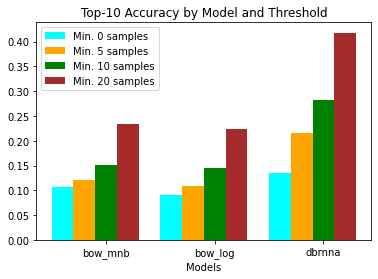

In [15]:
bar_plots(models, results)

#### Comparison: LSTM and Dense Layer Unit sizes (DBRNN-A)

Lastly, we compare the results of the original DBRNN-A against the modified DBRNN-A models with varying layer units sizes. 
The original DBRNN-A utilizes 1024 LSTM units and 1000 Dense units per layer. 

3 permutations are run for the modified models: 
- 512 LSTM units, 300 Dense units
- 300 LSTM units, 512 Dense units
- 300 LSTM units, 300 Dense units

These are selected to explore the possibility that a simpler architecture for the DBRNN-A could improve results. 

In [20]:
#Results processing
models_ = ['dbrnna', 'dbrnna_lstm512_dense300', 'dbrnna_lstm300_dense512', 'dbrnna_lstm300_dense300']
results_ = pd.read_csv(os.path.join(os.getcwd(), 'results/results.csv'))
results_.query(f"classifier in {models_} and metric == 'top_n' and metric_n == 10", inplace=True)
results_[[c for c in results_.columns if 'cv_' in c]] = results_[[c for c in results_.columns if 'cv_' in c]].round(4)*100.0

In [21]:
results_.query('threshold == 20').sort_values(by='average', ascending=False)[['classifier', 'average']]

,classifier,average
47,dbrnna_lstm300_dense300,0.470646
39,dbrnna_lstm300_dense512,0.467710
31,dbrnna_lstm512_dense300,0.429550
23,dbrnna,0.417897


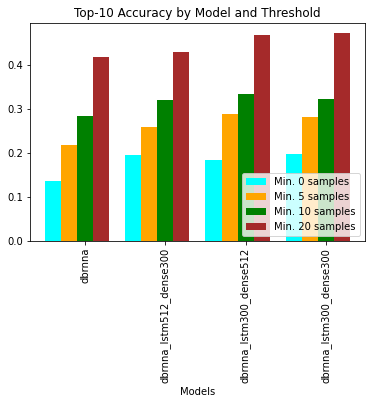

In [22]:
bar_plots(models_, results_, 'vertical', 4)

Based on the results, it appears that 300 LSTM units and 300 Dense units (the smallest permutation) improved performance against the originally large DBRNN-A with 1000+ units. This improvement is also noted across all training thresholds. 

# Conclusion and Future Direction
### Results
Given the data used in this project is different than the dataset used by Mani et al. [1], I anticipated different performance results, even when running identical models. However, a key limitation exists where Mani et al. implemented chronological time cross-validation (using a sliding window for training and testing sets) whereas this implementation implements a standard cross-validation procedure given the absence of a date/time feature in the available dataset. In addition, the DBRNN-A model proposed does appear to be heavily overfitting, possibly due to the size of the layers used and the general complexity of the model. 

The comparison analysis performed using different sizes of LSTM and Dense layer units revealed that performance of the proposed DBRNN-A was improved with a smaller, less complex model compared to the architecture size proposed by Mani et al. [1]. Therefore, there is additional work that can be done to explore hyper-parameter tuning to improve model performance since the smaller models shown here are more favorable due to their decreased complexity, faster training time, and increased resistance to overfitting. In addition, pretrained models like BERT (or other variants) can be employed in future work to attempt to capture more semantic information from bug reports to better enable developer assignment.   

### Learnings
In general, it was found that the text classification task becomes much more difficult when text input is extremely noisy and variable. Compared to other multi-class NLP tasks, bug triaging is particularly difficult because of the combination of both natural language as well as code traces and non-english word in the input data (bug reports) (compared to simpler classification tasks with english-only words like sentiment analysis for movies or news article classification). As a result, the processing steps and modeling become increasingly important due to this noise in order to achieve reasonable model accuracy.
In addition, it's been shown the importance of exploring less complex architectures as they may be helpful in improving overall model performance in noisy input environments. 

# References:

[1]: Senthil Mani, Anush Sankaran, and Rahul Aralikatte. 2019. DeepTriage: Exploring the Effectiveness of Deep Learning for Bug Triaging. In Proceedings of the ACM India Joint International Conference on Data Science and Management of Data (CoDS-COMAD '19). Association for Computing Machinery, New York, NY, USA, 171–179. DOI:https://doi.org/10.1145/3297001.3297023

[2]:  Pamela Bhattacharya and Iulian Neamtiu. Fine-grained incremental learning and multi-feature tossing graphs to improve bug triaging. In International Conference on Software Maintenance, pages 1–10, 2010.

[3]: Ahmed Tamrawi, Tung Thanh Nguyen, Jafar Al-Kofahi, and Tien N Nguyen. Fuzzy set-based automatic bug triaging: Nier track. In International Conference on Software Engineering, pages 884–887, 2011.
